In [1]:
# !pip install mpld3

In [2]:
import findspark, pyspark, os, sys
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext, SQLContext

from google.cloud import bigquery
client = bigquery.Client()

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

# Use mpld3 to change figure to HTML format
import mpld3
# mpld3.enable_notebook()

In [3]:
# Configure Spark and GraphFrames

SUBMIT_ARGS = "--packages graphframes:graphframes:0.8.2-spark3.1-s_2.12 pyspark-shell"
os.environ["PYSPARK_SUBMIT_ARGS"] = SUBMIT_ARGS

conf = SparkConf().setAll([('spark.jars', 'gs://spark-lib/bigquery/spark-3.1-bigquery-0.27.1-preview.jar')])
sc = SparkContext(conf=conf)

pyfiles = str(sc.getConf().get(u'spark.submit.pyFiles')).split(',')
sys.path.extend(pyfiles)

sqlContext = SQLContext(sparkContext=sc)
spark = sqlContext.sparkSession

bucket = "bd6893_data_yq"
spark.conf.set('temporaryGcsBucket', bucket)

from graphframes import *

:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-445caa68-d480-453d-93d5-80aaab0596f0;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.1-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 226ms :: artifacts dl 6ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.1-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	-----------------------------------------------

In [4]:
# Read October data from BigQuery

dataset_id = "transaction_network"
table_name = "graph_month_10"
edge_table_name = table_name + "_edge"
node_table_name = table_name + "_node"

In [5]:
edge_df_10 = spark.read.format('bigquery') \
    .option('table', f'big-data-6893-yunjie-qian:{dataset_id}.{edge_table_name}') \
    .load()

node_df_10 = spark.read.format('bigquery') \
    .option('table', f'big-data-6893-yunjie-qian:{dataset_id}.{node_table_name}') \
    .load()

g_10 = GraphFrame(node_df_10, edge_df_10)

In [6]:
# Read August data from BigQuery

dataset_id = "transaction_network"
table_name = "graph_month_08"
edge_table_name = table_name + "_edge"
node_table_name = table_name + "_node"

In [7]:
edge_df_08 = spark.read.format('bigquery') \
    .option('table', f'big-data-6893-yunjie-qian:{dataset_id}.{edge_table_name}') \
    .load()

node_df_08 = spark.read.format('bigquery') \
    .option('table', f'big-data-6893-yunjie-qian:{dataset_id}.{node_table_name}') \
    .load()

g_08 = GraphFrame(node_df_08, edge_df_08)

In [8]:
# Read one day's data from BigQuery as a correctness test

dataset_id = "transaction_network"
table_name = "graph_day_10_31"
edge_table_name = table_name + "_edge"
node_table_name = table_name + "_node"

In [9]:
edge_df_31 = spark.read.format('bigquery') \
    .option('table', f'big-data-6893-yunjie-qian:{dataset_id}.{edge_table_name}') \
    .load()

node_df_31 = spark.read.format('bigquery') \
    .option('table', f'big-data-6893-yunjie-qian:{dataset_id}.{node_table_name}') \
    .load()

g_31 = GraphFrame(node_df_31, edge_df_31)

In [10]:
# Compute Degree Centralization

def getCentralization(node_df):
    
    n = node_df.count()
    max_deg = node_df.agg({"degree": "max"}).head()["max(degree)"]
    sum_deg = node_df.agg({"degree": "sum"}).head()["sum(degree)"]
    
    c_denominator = (n-1) * (n-2) * 2
    c_numerator = n * max_deg - sum_deg
    
    network_centrality = float(c_numerator / c_denominator)
    
    return network_centrality

In [11]:
getCentralization(node_df_10)

0.07609729607130754

In [12]:
getCentralization(node_df_08)

0.09258939081216316

In [13]:
getCentralization(node_df_31)

0.03994063962494365

In [14]:
# Get degree distribution

def degree_dist(node_df):
    count = node_df.select('id', 'degree').groupBy('degree').count().orderBy('degree', ascending=True)
    return count

In [15]:
deg_dist_10 = degree_dist(node_df_10)
deg_dist_08 = degree_dist(node_df_08)

deg_08 = deg_dist_08.select('degree').rdd.flatMap(lambda x: x).collect()
count_08 = deg_dist_08.select('count').rdd.flatMap(lambda x: x).collect()
deg_10 = deg_dist_10.select('degree').rdd.flatMap(lambda x: x).collect()
count_10 = deg_dist_10.select('count').rdd.flatMap(lambda x: x).collect()

In [16]:
plt.rcParams['figure.figsize'] = (15, 10)

In [17]:
# The function to change figure to HTML format

def to_html(fig, fig_name):
    
    html_fragment = mpld3.fig_to_html(fig, figid = 'fig1')

    html_doc = f'''
    <style type="text/css">
    div#fig1 {{ text-align: center }}
    </style>

    {html_fragment}
    '''

    Html_file= open(f"{fig_name}.html", "w")
    Html_file.write(html_doc)
    Html_file.close()

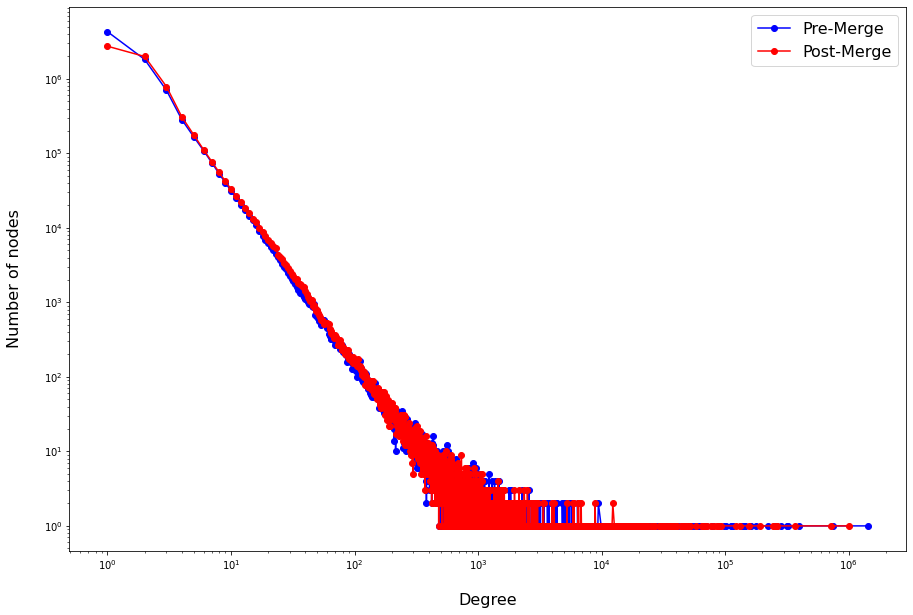

In [18]:
fig, ax = plt.figure(), plt.axes()

ax.loglog(deg_08, count_08, 'bo-', label='Pre-Merge')
ax.loglog(deg_10, count_10, 'ro-', label='Post-Merge')

ax.set_xlabel('\nDegree', fontsize=16)
ax.set_ylabel('Number of nodes\n', fontsize=16)
ax.legend(fontsize=16)

In [19]:
to_html(fig, 'deg_dist')

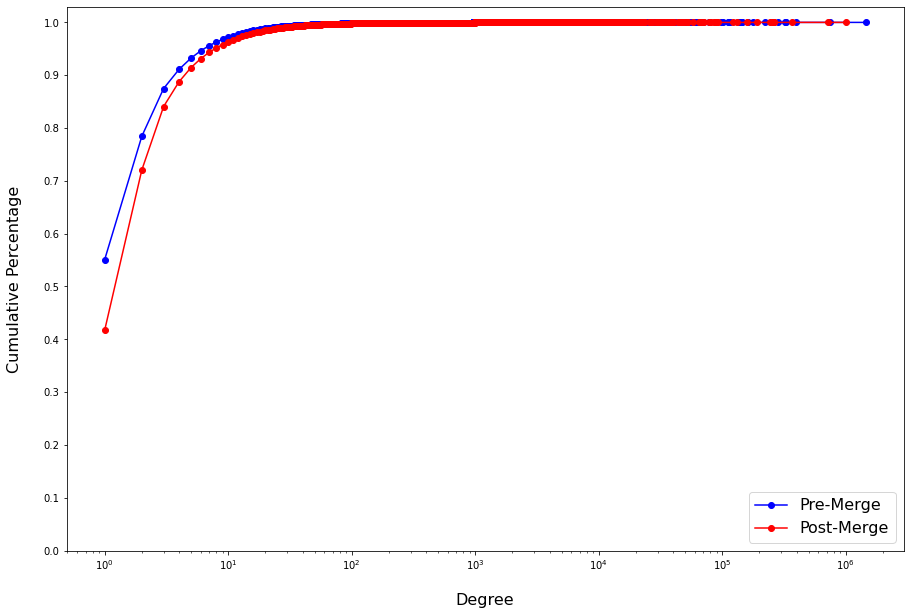

In [20]:
fig, ax = plt.figure(), plt.axes()

ax.plot(deg_08, np.cumsum(np.array(count_08) / sum(count_08)), 'bo-', label='Pre-Merge')
ax.plot(deg_10, np.cumsum(np.array(count_10) / sum(count_10)), 'ro-', label='Post-Merge')

ax.set_xlabel('\nDegree', fontsize=16)
ax.set_ylabel('Cumulative Percentage\n', fontsize=16)
ax.set_xscale('log')

ax.legend(fontsize=16, loc='lower right')
ax.set_yticks(np.arange(0, 1.01, 0.1))

In [21]:
to_html(fig, 'deg_dist_ccdf')

In [22]:
# Get transaction time distribution

def trans_dist(node_df):
    node_df = node_df.withColumn('total_transaction', node_df.out_total_transaction + node_df.in_total_transaction)
    count = node_df.select('total_transaction').groupBy('total_transaction').count().orderBy('total_transaction', ascending=True)
    return count

In [23]:
trans_dist_10 = trans_dist(node_df_10)
trans_dist_08 = trans_dist(node_df_08)

trans_08 = trans_dist_08.select('total_transaction').rdd.flatMap(lambda x: x).collect()
count_08 = trans_dist_08.select('count').rdd.flatMap(lambda x: x).collect()
trans_10 = trans_dist_10.select('total_transaction').rdd.flatMap(lambda x: x).collect()
count_10 = trans_dist_10.select('count').rdd.flatMap(lambda x: x).collect()

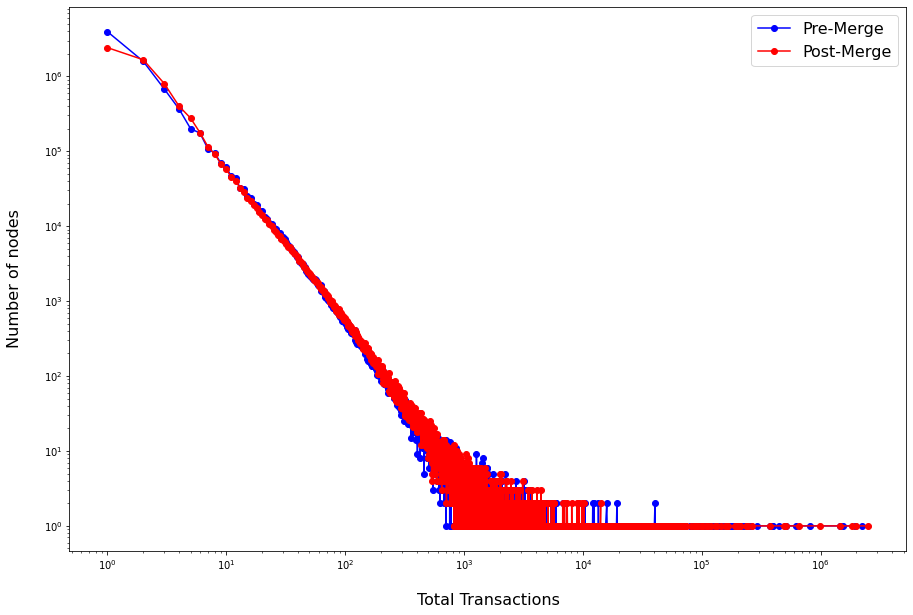

In [24]:
fig, ax = plt.figure(), plt.axes()

ax.loglog(trans_08, count_08, 'bo-', label='Pre-Merge')
ax.loglog(trans_10, count_10, 'ro-', label='Post-Merge')

ax.set_xlabel('\nTotal Transactions', fontsize=16)
ax.set_ylabel('Number of nodes\n', fontsize=16)
ax.legend(fontsize=16)

In [25]:
to_html(fig, 'trans_dist')

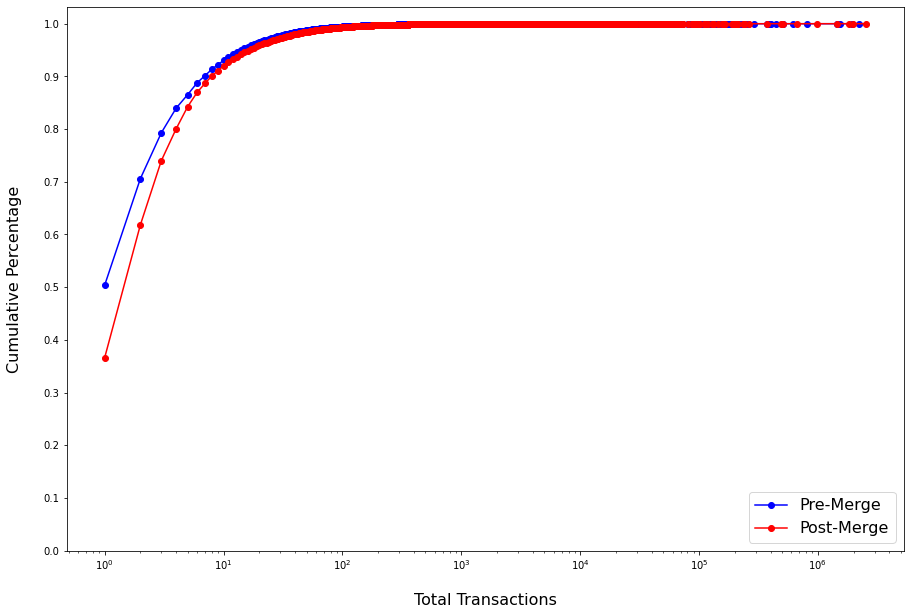

In [26]:
fig, ax = plt.figure(), plt.axes()

ax.plot(trans_08, np.cumsum(np.array(count_08) / sum(count_08)), 'bo-', label='Pre-Merge')
ax.plot(trans_10, np.cumsum(np.array(count_10) / sum(count_10)), 'ro-', label='Post-Merge')

ax.set_xlabel('\nTotal Transactions', fontsize=16)
ax.set_ylabel('Cumulative Percentage\n', fontsize=16)
ax.set_xscale('log')

ax.legend(fontsize=16, loc='lower right')
ax.set_yticks(np.arange(0, 1.01, 0.1))

In [27]:
to_html(fig, 'trans_dist_ccdf')

In [28]:
# Get transaction value distribution

def value_dist(node_df):
    node_df = node_df.withColumn('total_value', node_df.out_total_value + node_df.in_total_value)
    node_df = node_df.withColumn('total_value', node_df.total_value * 1e-18)
    node_df = node_df.withColumn('total_value', node_df.total_value.cast('int'))
    count = node_df.select('total_value').groupBy('total_value').count().orderBy('total_value', ascending=True)
    return count

In [29]:
value_dist_10 = value_dist(node_df_10)
value_dist_08 = value_dist(node_df_08)

value_08 = value_dist_08.select('total_value').rdd.flatMap(lambda x: x).collect()[1:]
count_08 = value_dist_08.select('count').rdd.flatMap(lambda x: x).collect()[1:]
value_10 = value_dist_10.select('total_value').rdd.flatMap(lambda x: x).collect()[1:]
count_10 = value_dist_10.select('count').rdd.flatMap(lambda x: x).collect()[1:]

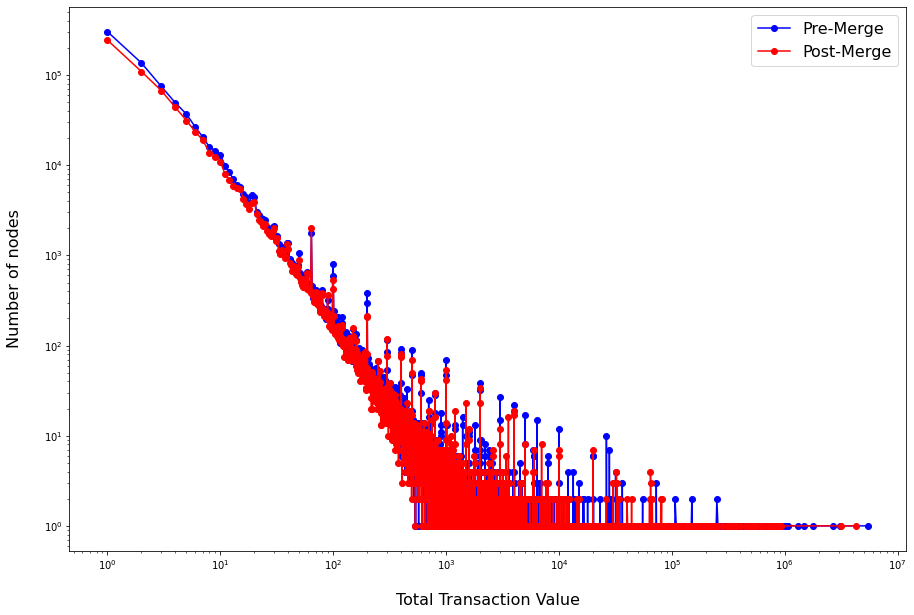

In [30]:
fig, ax = plt.figure(), plt.axes()

ax.loglog(value_08, count_08, 'bo-', label='Pre-Merge')
ax.loglog(value_10, count_10, 'ro-', label='Post-Merge')

ax.set_xlabel('\nTotal Transaction Value', fontsize=16)
ax.set_ylabel('Number of nodes\n', fontsize=16)
ax.legend(fontsize=16)

In [31]:
to_html(fig, 'value_dist')

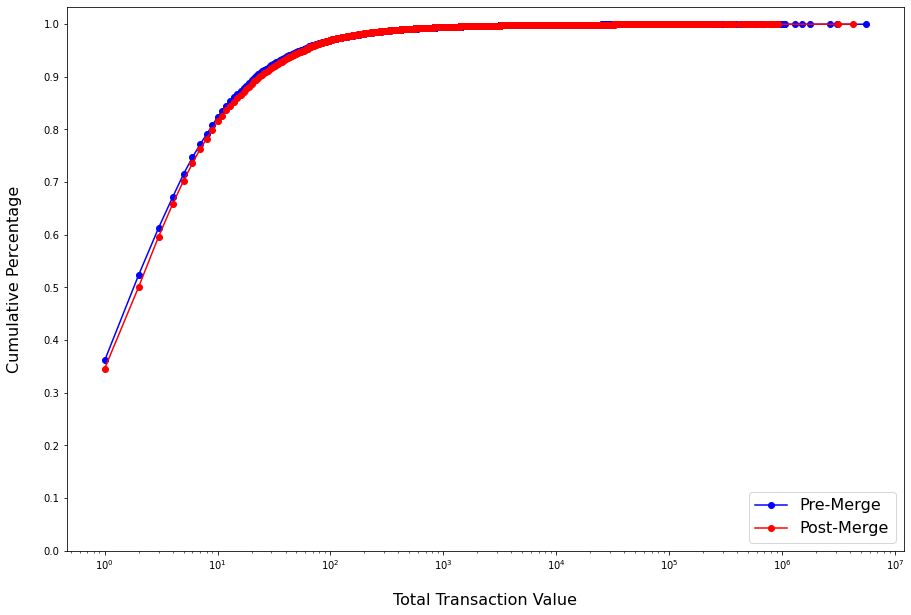

In [32]:
fig, ax = plt.figure(), plt.axes()

ax.plot(value_08, np.cumsum(np.array(count_08) / sum(count_08)), 'bo-', label='Pre-Merge')
ax.plot(value_10, np.cumsum(np.array(count_10) / sum(count_10)), 'ro-', label='Post-Merge')

ax.set_xlabel('\nTotal Transaction Value', fontsize=16)
ax.set_ylabel('Cumulative Percentage\n', fontsize=16)
ax.set_xscale('log')

ax.legend(fontsize=16, loc='lower right')
ax.set_yticks(np.arange(0, 1.01, 0.1))

In [33]:
to_html(fig, 'value_dist_ccdf')

In [34]:
# Get edge attributes distribution

def edge_dist(edge_df, feature):
    
    eth_rate = 1e-9
    wei_rate = 1e-18
    
    if feature == 'gas':
        edge_df = edge_df.withColumn('min_gas_price', edge_df.min_gas_price * eth_rate)
        edge_df = edge_df.withColumn('min_gas_price', edge_df.min_gas_price.cast('int'))
        count = edge_df.select('min_gas_price').groupBy('min_gas_price').count().orderBy('min_gas_price', ascending=True)
    
    if feature == 'value':   
        edge_df = edge_df.withColumn('total_value', edge_df.total_value * wei_rate)
        edge_df = edge_df.withColumn('total_value', edge_df.total_value.cast('int'))
        count = edge_df.select('total_value').groupBy('total_value').count().orderBy('total_value', ascending=True)
    
    if feature == 'count':   
        edge_df = edge_df.withColumn('transaction_count', edge_df.transaction_count.cast('int'))
        count = edge_df.select('transaction_count').groupBy('transaction_count').count().orderBy('transaction_count', ascending=True)
    
    return count

In [35]:
edge_dist_10 = edge_dist(edge_df_10, 'gas')
edge_dist_08 = edge_dist(edge_df_08, 'gas')

19.115154013958335


14.883967954518658


In [36]:
edge_08 = edge_dist_08.select('min_gas_price').rdd.flatMap(lambda x: x).collect()
edge_count_08 = edge_dist_08.select('count').rdd.flatMap(lambda x: x).collect()
edge_10 = edge_dist_10.select('min_gas_price').rdd.flatMap(lambda x: x).collect()
edge_count_10 = edge_dist_10.select('count').rdd.flatMap(lambda x: x).collect()

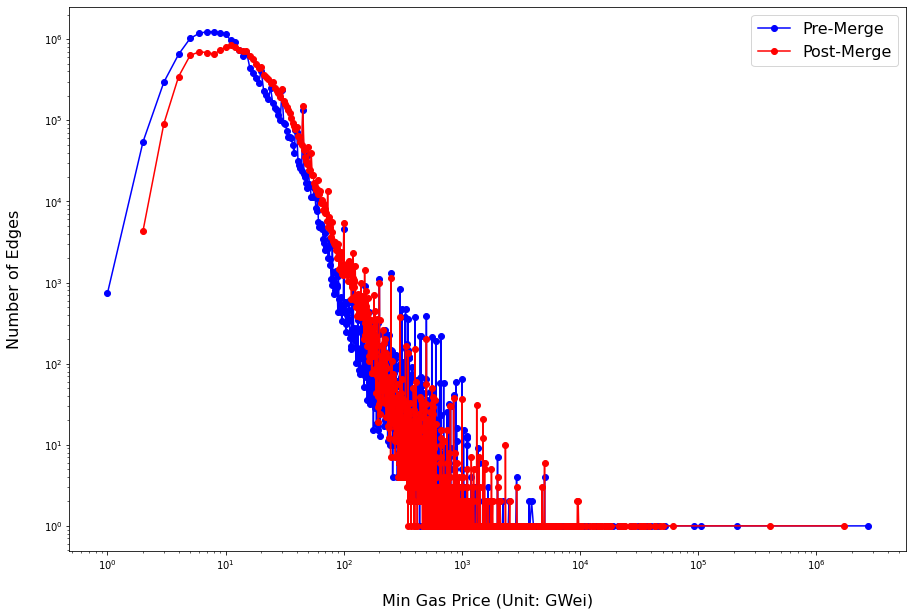

In [37]:
fig, ax = plt.figure(), plt.axes()

ax.loglog(edge_08, edge_count_08, 'bo-', label='Pre-Merge')
ax.loglog(edge_10, edge_count_10, 'ro-', label='Post-Merge')

ax.set_xlabel('\nMin Gas Price (Unit: GWei)', fontsize=16)
ax.set_ylabel('Number of Edges\n', fontsize=16)
ax.legend(fontsize=16)

In [38]:
to_html(fig, 'gas_price_dist')

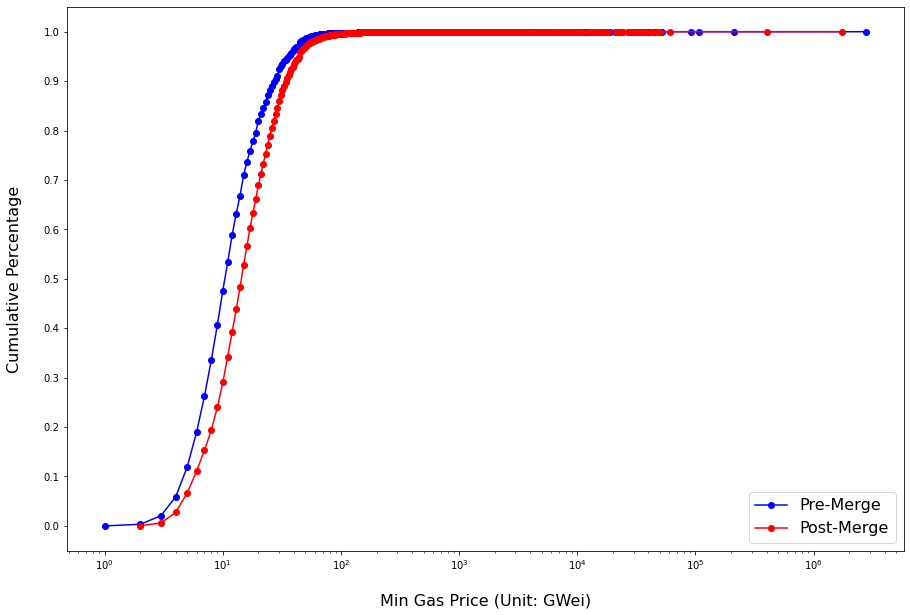

In [39]:
fig, ax = plt.figure(), plt.axes()

ax.plot(edge_08, np.cumsum(np.array(edge_count_08) / sum(edge_count_08)), 'bo-', label='Pre-Merge')
ax.plot(edge_10, np.cumsum(np.array(edge_count_10) / sum(edge_count_10)), 'ro-', label='Post-Merge')

ax.set_xlabel('\nMin Gas Price (Unit: GWei)', fontsize=16)
ax.set_ylabel('Cumulative Percentage\n', fontsize=16)
ax.set_xscale('log')

ax.legend(fontsize=16, loc='lower right')
ax.set_yticks(np.arange(0, 1.01, 0.1))

In [40]:
to_html(fig, 'gas_price_dist_ccdf')

In [41]:
edge_dist_10 = edge_dist(edge_df_10, 'value')
edge_dist_08 = edge_dist(edge_df_08, 'value')

edge_08 = edge_dist_08.select('total_value').rdd.flatMap(lambda x: x).collect()[1:]
edge_count_08 = edge_dist_08.select('count').rdd.flatMap(lambda x: x).collect()[1:]
edge_10 = edge_dist_10.select('total_value').rdd.flatMap(lambda x: x).collect()[1:]
edge_count_10 = edge_dist_10.select('count').rdd.flatMap(lambda x: x).collect()[1:]

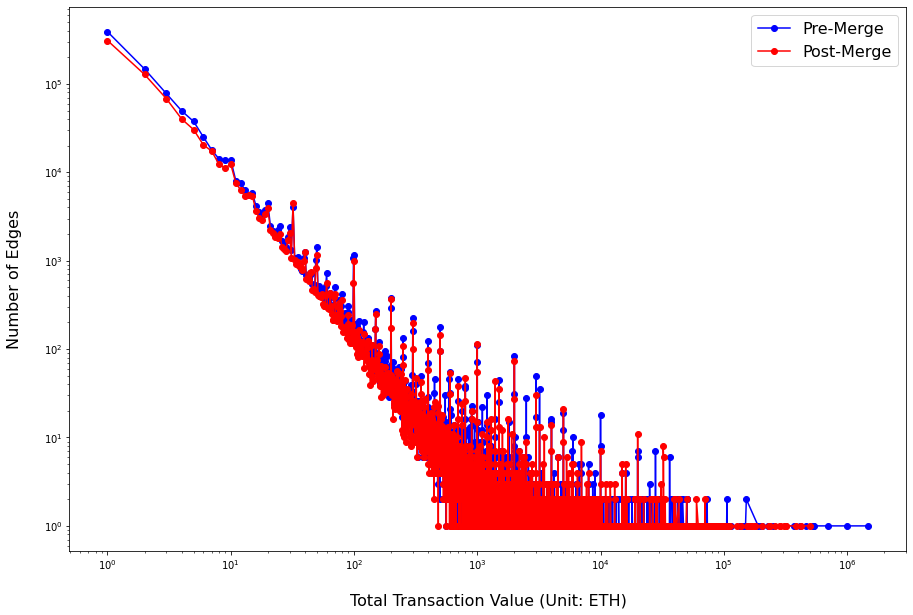

In [42]:
fig, ax = plt.figure(), plt.axes()

ax.loglog(edge_08, edge_count_08, 'bo-', label='Pre-Merge')
ax.loglog(edge_10, edge_count_10, 'ro-', label='Post-Merge')

ax.set_xlabel('\nTotal Transaction Value (Unit: ETH)', fontsize=16)
ax.set_ylabel('Number of Edges\n', fontsize=16)
ax.legend(fontsize=16)

In [43]:
to_html(fig, 'trans_value_dist')

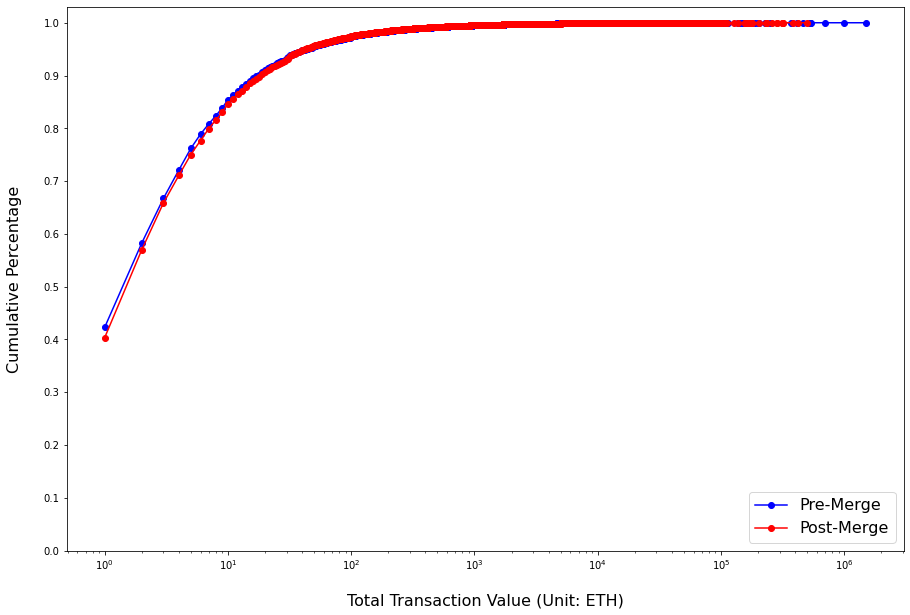

In [44]:
fig, ax = plt.figure(), plt.axes()

ax.plot(edge_08, np.cumsum(np.array(edge_count_08) / sum(edge_count_08)), 'bo-', label='Pre-Merge')
ax.plot(edge_10, np.cumsum(np.array(edge_count_10) / sum(edge_count_10)), 'ro-', label='Post-Merge')

ax.set_xlabel('\nTotal Transaction Value (Unit: ETH)', fontsize=16)
ax.set_ylabel('Cumulative Percentage\n', fontsize=16)
ax.set_xscale('log')

ax.legend(fontsize=16, loc='lower right')
ax.set_yticks(np.arange(0, 1.01, 0.1))

In [45]:
to_html(fig, 'trans_value_dist_ccdf')